Trial 254 Complete [00h 00m 42s]
val_accuracy: 0.6568750143051147

Best val_accuracy So Far: 0.7873697876930237
Total elapsed time: 02h 51m 21s
Optimal number of hidden layers: 4
Optimal number of units in layer 1: 192
Optimal dropout rate in layer 1: 0.2
Optimal number of units in layer 2: 256
Optimal dropout rate in layer 2: 0.1
Optimal number of units in layer 3: 224
Optimal dropout rate in layer 3: 0.1
Optimal number of units in layer 4: 224
Optimal dropout rate in layer 4: 0.1
Optimal learning rate: 0.0001
Epoch 1/200


4800/4800 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.5596 - loss: 1.0956 - val_accuracy: 0.6699 - val_loss: 0.7870
Epoch 2/200
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.6509 - loss: 0.8196 - val_accuracy: 0.6862 - val_loss: 0.7397
Epoch 3/200
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.6726 - loss: 0.7726 - val_accuracy: 0.7016 - val_loss: 0.7098
Epoch 4/200
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.6866 - loss: 0.7448 - val_accuracy: 0.7029 - val_loss: 0.6983
Epoch 5/200
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.6956 - loss: 0.7245 - val_accuracy: 0.7137 - val_loss: 0.6815
Epoch 6/200
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.7003 - loss: 0.7141 - val_accuracy: 0.7170 - val_loss: 0.6716
Epoch 7/200
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.7044 - loss: 0.7037 - val_accuracy: 0.7196 - val_loss: 0.6611
Epoch 8/200
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.7094 - loss: 0.6899 - val_

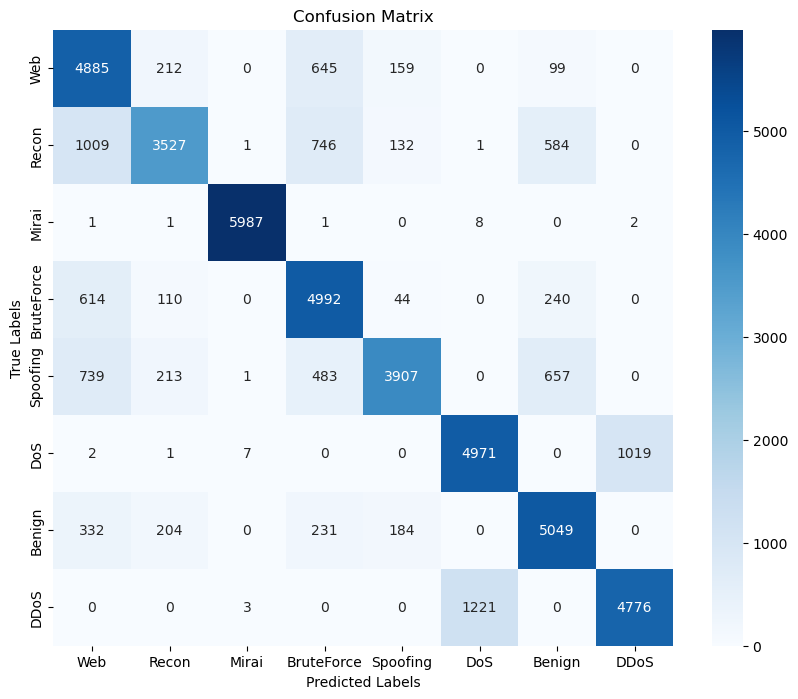

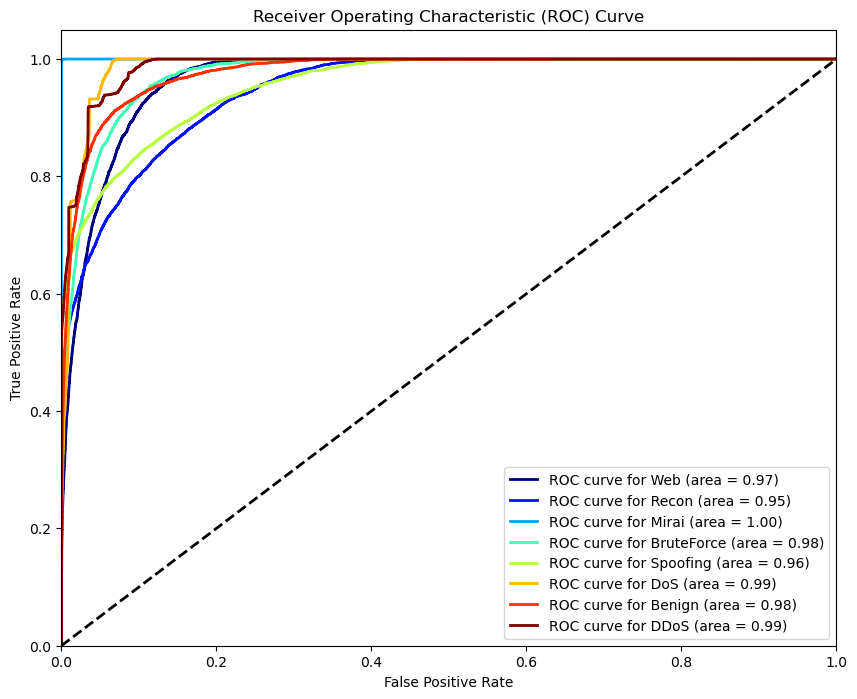

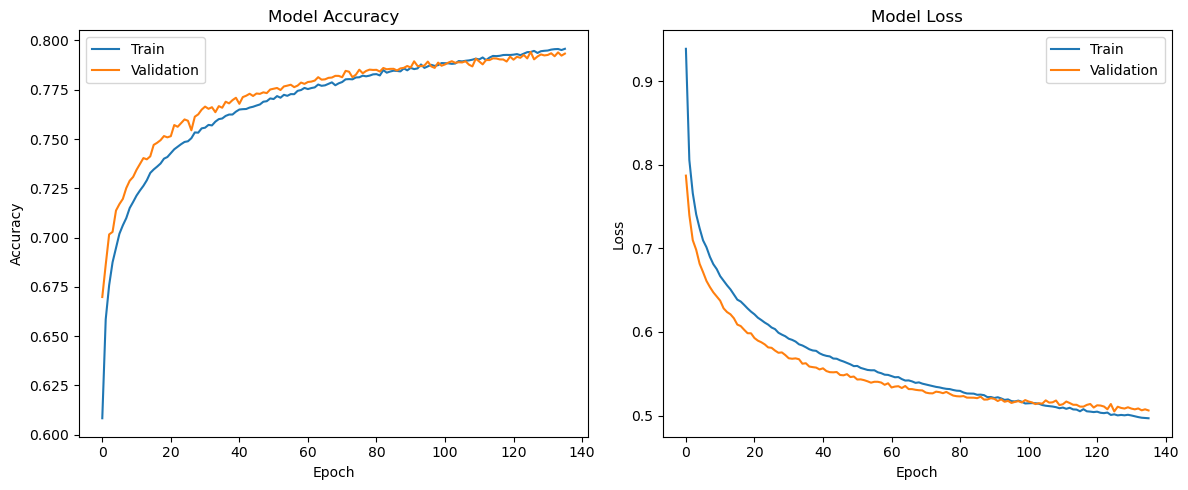

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Data Loading and Preprocessing

try:
    data = pd.read_csv('/Users/bodapati/Downloads/balanced_dataset3.csv')
except FileNotFoundError:
    print("Error: The file 'balanced_dataset3.csv' was not found. Please check the file path.")
    exit()

features = ['flow_duration', 'Header_Length', 'Protocol Type', 'Duration', 'Rate', 'Srate', 'Drate',
            'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number',
            'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count', 'fin_count', 'urg_count',
            'rst_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP',
            'ARP', 'ICMP', 'IPv', 'LLC', 'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT',
            'Number', 'Magnitue', 'Radius', 'Covariance', 'Variance', 'Weight']
target = 'label'

X = data[features]
y = data[target]

numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

X_processed = preprocessor.fit_transform(X)

y_encoded, y_labels = pd.factorize(y)
y_categorical = to_categorical(y_encoded)

X_train, X_test, y_train, y_test = train_test_split(X_processed, y_categorical, test_size=0.2, random_state=42, stratify=y_encoded)

# 2. Hyperparameter Tuning with Keras Tuner

def build_model(hp):
    model = Sequential()
    
    # Tune the number of hidden layers
    for i in range(hp.Int('num_hidden_layers', 2, 5)):
        model.add(Dense(
            units=hp.Int(f'units_{i}', min_value=32, max_value=256, step=32),
            activation='relu'
        ))
        # Tune the dropout rate
        model.add(Dropout(hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.5, step=0.1)))
    
    model.add(Dense(len(y_labels), activation='softmax'))

    # Tune the learning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=100,
    directory='my_dir',
    project_name='traffic_classification'
)

# Set up EarlyStopping callback
stop_early = EarlyStopping(monitor='val_loss', patience=10)

# Start the search for the best model architecture
tuner.search(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Optimal number of hidden layers: {best_hps.get('num_hidden_layers')}")
for i in range(best_hps.get('num_hidden_layers')):
    print(f"Optimal number of units in layer {i+1}: {best_hps.get(f'units_{i}')}")
    print(f"Optimal dropout rate in layer {i+1}: {best_hps.get(f'dropout_{i}')}")
print(f"Optimal learning rate: {best_hps.get('learning_rate')}")

# Build the final model with the optimal hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train the best model
history = best_model.fit(X_train, y_train, epochs=200, validation_split=0.2, callbacks=[stop_early])

# 3. Model Evaluation and Visualization

loss, accuracy = best_model.evaluate(X_test, y_test, verbose=0)
print(f"\nFinal Model Accuracy on Test Set: {accuracy*100:.2f}%")

y_pred_probs = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=y_labels))


cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y_labels, yticklabels=y_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


plt.figure(figsize=(10, 8))
colors = plt.cm.jet(np.linspace(0, 1, len(y_labels)))

for i, label in enumerate(y_labels):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], lw=2,
             label=f'ROC curve for {label} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

plt.figure(figsize=(12, 5))
 
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()